In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
data_dir = "/".join((".", "data"))
train_data_source = 'train_tokenized'

### Load dataset and sentence to sequence transform

In [3]:
# load article tokenized
with open(data_dir + "/" + train_data_source, 'rb') as file:
    article_df = pickle.load(file)
article_df.head(5)

,id,sentence,class,keyword_flag
0,0,"[參與, 糖分, 代謝, 抑制, 壞菌, 生長, 遠離, 疾病, 延年益壽, 益壽, 骨質,...",1,1
1,1,"[增強, 抵抗, 抵抗力, 抗力, 長期, 處於, 熬夜, 壓力, 生理, 狀態, 下, 造...",1,1
2,2,"[磷脂, 醯, 絲氨酸, 氨酸, 升, 記憶, 促進, 大腦, 新陳代謝, 代謝, 改善, ...",1,1
3,3,"[長庚, 醫學, 團隊, 研發, 新陳代謝, 代謝, 科, 減重, 門診, 家, 醫科, 指...",1,1
4,4,"[淨化, 腸胃, 好, 健康, 促進, 腸胃, 蠕動, 瘦身, 燃燒, 脂肪, 減肥, 減肥...",1,1


In [4]:
print("違法廣告: %d則" % (article_df[article_df["class"] == 1].shape[0]))
print("合法廣告: %d則" % (article_df[article_df["class"] == 0].shape[0]))

違法廣告: 583則
合法廣告: 354則


### create word ID mapping and word vector

In [5]:
#w2v = word2vec.Word2Vec.load('word2vec_model/CBOW')
w2v = word2vec.Word2Vec.load('word2vec_model/zh.bin')
word2id = {k:i for i, k in enumerate(w2v.wv.vocab.keys())}
id2word = {i:k for k, i in word2id.items()}
word2id_len = len(word2id) - 1
print('word2id_len:', word2id_len)

#WORD2VEC_DIMENTION = 128
WORD2VEC_DIMENTION = 300
embedding = np.zeros((word2id_len+2, WORD2VEC_DIMENTION))
for k, v in word2id.items():
    embedding[v] = w2v.wv[k]
    # 謹慎列印，資料量很大
    #print('k=%s, v=%d'%(k, v))
    #print('embedding[v]=', embedding[v])
print(embedding)

word2id_len: 50100
[[ 0.50530547  0.79481578 -0.05217843 ...  0.51448345 -0.96831626
  -0.55472964]
 [ 0.24807508 -0.02318559  0.32145366 ... -0.15051267  0.23067704
   1.49064207]
 [ 0.13427982 -0.89184523  0.50744736 ... -0.566338   -1.08766747
  -0.01587926]
 ...
 [-2.05965161  0.45601803 -0.78086191 ...  0.00390649 -0.97316802
  -0.48760489]
 [ 0.32159725  0.35988423 -0.18983532 ... -0.33511752  0.37509933
   0.21154639]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### sentence to sequence transform

In [6]:
#
# 選取多少詞來當作輸入
#
PICK_WORDS = 40  # 選前面40個詞當作輸入

In [7]:
docs_id = []

for setence in article_df["sentence"]:
    text = setence[:PICK_WORDS]
    #print(text)
    ids = [word2id_len+1]*PICK_WORDS  # 初始化list
    
    #for w in text:
    #    if w in word2id:
    #        ids[:len(text)] = word2id[w]
    #    else
    #        ids[:len(text)] = word2id_len+1
    ids[:len(text)] = [word2id[w] if w in word2id else word2id_len+1 for w in text]
    print(ids)

    docs_id.append(ids)

#  轉換後的sequence合併到dataframe    
article_df["sentence_seq"] = docs_id
article_df.head()

[15786, 50101, 38458, 41424, 50101, 32869, 37253, 22318, 50101, 50101, 15999, 50101, 50101, 25184, 50101, 50101, 40998, 40644, 30211, 6999, 22318, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101, 50101]
[34162, 31140, 25634, 50101, 50101, 50101, 50101, 39876, 42149, 32371, 31369, 7511, 2671, 50101, 38458, 16102, 23377, 20330, 6999, 2938, 1311, 50101, 50101, 18760, 35032, 50101, 50101, 50101, 23517, 839, 4433, 22354, 35032, 10554, 9498, 50101, 50101, 46175, 50101, 38458]
[32481, 49224, 50101, 21509, 15323, 41123, 10554, 15052, 50101, 38458, 44800, 38575, 50101, 3628, 11205, 11687, 38458, 15602, 50101, 1244, 1311, 50101, 7601, 21827, 50101, 11687, 1311, 50101, 7601, 7063, 43566, 43367, 50101, 44800, 41123, 50101, 10068, 43367, 50101, 1311]
[50101, 48447, 9072, 29197, 50101, 38458, 46122, 50101, 50101, 1047, 50101, 14277, 32366, 46078, 48016, 50101, 50101, 23621, 24972, 2719, 25000, 13048, 50101, 22954, 29906, 30

,id,sentence,class,keyword_flag,sentence_seq
0,0,"[參與, 糖分, 代謝, 抑制, 壞菌, 生長, 遠離, 疾病, 延年益壽, 益壽, 骨質,...",1,1,"[15786, 50101, 38458, 41424, 50101, 32869, 372..."
1,1,"[增強, 抵抗, 抵抗力, 抗力, 長期, 處於, 熬夜, 壓力, 生理, 狀態, 下, 造...",1,1,"[34162, 31140, 25634, 50101, 50101, 50101, 501..."
2,2,"[磷脂, 醯, 絲氨酸, 氨酸, 升, 記憶, 促進, 大腦, 新陳代謝, 代謝, 改善, ...",1,1,"[32481, 49224, 50101, 21509, 15323, 41123, 105..."
3,3,"[長庚, 醫學, 團隊, 研發, 新陳代謝, 代謝, 科, 減重, 門診, 家, 醫科, 指...",1,1,"[50101, 48447, 9072, 29197, 50101, 38458, 4612..."
4,4,"[淨化, 腸胃, 好, 健康, 促進, 腸胃, 蠕動, 瘦身, 燃燒, 脂肪, 減肥, 減肥...",1,1,"[7671, 50101, 13144, 35032, 10554, 50101, 5010..."


In [8]:
a_docs_id = np.array(docs_id)
print(a_docs_id)

[[15786 50101 38458 ... 50101 50101 50101]
 [34162 31140 25634 ... 46175 50101 38458]
 [32481 49224 50101 ... 43367 50101  1311]
 ...
 [38804  5935 50101 ... 50101 50101 50101]
 [31430  6028 50101 ... 18031 32436 35032]
 [50101  8492 27980 ... 50101 50101 50101]]


### Create data generator

In [9]:
#number_of_classes = len(category_list)
number_of_classes = 2  # 合法、違法廣告
number_of_classes_binary = 1
sample_per_class  = 8

epochs            = 500  #100
batch_size        = number_of_classes * sample_per_class
update_per_epochs = 100  #100
hidden_layer_size = 32 #64 #256
number_of_layers  = 2
learning_rate     = 0.001  #0.001
#dropout           = False
dropout_rate      = 0.5
wv                = embedding
gradient_clip_margin = 4

patience = 5  # early stop patiences
n_patience = 0

In [10]:
def train_data_generator(df, bz):
    # bz: batch size 
    dfs = [sub_df for key, sub_df in df.groupby('class')]
    df_n = len(dfs)
    
    while True:
        selected = pd.concat([sub_df.sample(int(bz/number_of_classes)) for sub_df in dfs], axis=0)
        selected = selected.sample(frac=1)
        #print("selected: ", selected)
        x = selected['sentence_seq'].tolist()
        x = np.array(x)
        y = selected.as_matrix(columns=['class'])  # kvdbg+
        #y = pd.get_dummies(selected['class'], '').as_matrix()  # one-hot encoding
        #print(y)
        
        yield x, y
        
def test_data_generator(df, docs_id):
    #print(df)
    docs_id = np.array(docs_id)
    xx = docs_id[df.index]
    x = df['sentence_seq'].tolist()
    x = np.array(x)
    #print(df[["sentence","sentence_seq"]])
    y = df.as_matrix(columns=['class'])
    #kvdbg-y = df['class'].as_matrix()
    return x, y

### 切割資料準備訓練

In [11]:
train_df, validate_df = train_test_split(article_df, test_size=0.2, shuffle=True, stratify=article_df['class'])

train_generate = train_data_generator(train_df, batch_size)
X_test, y_test = test_data_generator(validate_df, docs_id)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Create LSTM

In [12]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    #loss = tf.reduce_sum(tf.pow(logits - targets, 2))/batch_size
    #kvdbg-cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)) #kvdbg+
     

    #Cliping the gradient loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gradients = optimizer.compute_gradients(cross_entropy)
    capped_gradients = [(tf.clip_by_value(grad, (-1)*grad_clip_margin, grad_clip_margin), var) for grad, var in gradients if grad is not None]
    train_optimizer = optimizer.apply_gradients(capped_gradients)   
    #curr_learning_rate = (optimizer._lr_t * tf.sqrt(1 - optimizer._beta1) / (1 - optimizer._beta2))
    curr_learning_rate = optimizer._lr_t
    

    return cross_entropy, train_optimizer, curr_learning_rate

In [13]:
main_graph = tf.Graph()

with main_graph.as_default():    
    ##defining placeholders##
    with tf.name_scope('input_layer'):
        inputs = tf.placeholder(tf.int32, [None, PICK_WORDS], name='input_data')
        tf.add_to_collection("training_collection", inputs)  # 把這個變數存起來
        
        targets = tf.placeholder(tf.float32, [None, number_of_classes_binary], name='targets')
        tf.add_to_collection("training_collection", inputs)  # 把這個變數存起來
        
        bz = tf.placeholder(tf.int32, [], name='batch_size')
        
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        tf.add_to_collection("training_collection", inputs)  # 把這個變數存起來
        
    ## embedding lookup table
    with tf.variable_scope('embedding_layer'):    
        em_W = tf.Variable(wv.astype(np.float32), trainable=True)  #wv.shape = (sentences_count, word2vec_dimension)
        x = tf.nn.embedding_lookup(em_W, inputs)    #x.shape = (?, PICK_WORDS, word2vec_dimension)
        
    ##LSTM layer##
    ##Bi-directional LSTM
    with tf.variable_scope("Bidirectional_LSTM_layer"):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
        #if dropout:
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
            
        init_state_fw = lstm_cell.zero_state(tf.shape(inputs)[0], tf.float32)
        init_state_bw = lstm_cell.zero_state(tf.shape(inputs)[0], tf.float32)
        
        ((outputs_fw, outputs_bw), (outputs_state_fw, outputs_state_bw)) = \
        tf.nn.bidirectional_dynamic_rnn(lstm_cell, lstm_cell, x, 
                                        initial_state_fw=init_state_fw,
                                        initial_state_bw=init_state_bw)
        
        outputs = tf.concat((outputs_fw, outputs_bw), 2)
        print(outputs)
        #final_state_c = tf.concat((outputs_state_fw.c, outputs_state_bw.c), 1)
        #final_state_h = tf.concat((outputs_state_fw.h, outputs_state_bw.h), 1)
        #outputs = tf.contrib.rnn.LSTMStateTuple(c=final_state_c, h=final_state_h)

    ##Output layer##   
    with tf.variable_scope('output_layer'):
        x = outputs[:, -1, :] 
        logits = tf.layers.dense(inputs=x, units=number_of_classes_binary, activation=None,
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.005),)
        tf.add_to_collection("training_collection", logits)  # 把這個變數存起來
        
        class_prob = tf.nn.sigmoid(logits, name='class_probability')
        tf.add_to_collection("training_collection", class_prob)  # 把這個變數存起來
        
    ##loss and optimization##
    with tf.name_scope('loss_and_opt'):
        loss, opt, curr_lr = opt_loss(logits, targets, learning_rate, gradient_clip_margin)
    
    ##accuracy
    with tf.name_scope('evaluate'):
        predictions = tf.greater(class_prob, 0.5, name="predictions")
        tf.add_to_collection("training_collection", inputs)  # 把這個變數存起來
        
        correct_prediction = tf.equal(tf.round(class_prob), targets)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 建立 saver 物件
    saver = tf.train.Saver()
    
    init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("Bidirectional_LSTM_layer/concat:0", shape=(

### Train Neural Network

In [14]:
with tf.Session() as sess:
    sess = tf.Session(graph=main_graph)
    sess.run(init)

In [15]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epochs):
    traind_loss = []
    traind_scores = []
    test_scores = []

    for j in range(update_per_epochs):
        X_batch, y_batch = next(train_generate) 
        
        train_logits, train_prob, train_loss, train_acc, optimizer = \
        sess.run([logits, class_prob, loss, accuracy, opt], 
                 feed_dict={inputs:X_batch,
                            targets:y_batch,
                            bz:np.array(batch_size),
                            keep_prob:(1 - dropout_rate)})
        
        traind_loss.append(train_loss)
        traind_scores.append(train_acc)
        
    #kvdbg- y_test_onehot = pd.get_dummies(y_test, '')  # one-hot encoding
    #print('y_test:', y_test)
    
    test_logits, test_prob, test_loss, test_acc = \
    sess.run([logits, class_prob, loss, accuracy], 
             #kvdbg-feed_dict={inputs:X_test, targets:y_test_onehot, bz:np.array(len(X_test))})
             feed_dict={inputs:X_test, 
                        targets:y_test, 
                        bz:np.array(len(X_test)),
                        keep_prob:(1 - dropout_rate)})
    
    #print("test_prob: ", test_prob)
    
    train_loss_list.append(np.mean(traind_loss))
    train_acc_list.append(np.mean(traind_scores))
    
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    if (i % 1) == 0:
        print('Epoch {}/{}'.format(i, epochs), 
              ' Train loss: {:.3f}'.format(np.mean(traind_loss)),'Train acc: {:.3f}'.format(np.mean(traind_scores)),
              ' Test loss: {:.3f}'.format(test_loss), ' Test acc: {:.3f}'.format(test_acc))
        
    if test_loss >= np.min(test_loss_list):
        n_patience += 1
    else:
        n_patience = 0

    if n_patience > patience:
        print("The model didn't improve for %i rounds, break it!" % patience)
        break

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


Epoch 0/500  Train loss: 0.381 Train acc: 0.841  Test loss: 0.221  Test acc: 0.920
Epoch 1/500  Train loss: 0.137 Train acc: 0.965  Test loss: 0.172  Test acc: 0.947
Epoch 2/500  Train loss: 0.067 Train acc: 0.985  Test loss: 0.151  Test acc: 0.963
Epoch 3/500  Train loss: 0.034 Train acc: 0.994  Test loss: 0.147  Test acc: 0.963
Epoch 4/500  Train loss: 0.030 Train acc: 0.994  Test loss: 0.172  Test acc: 0.952
Epoch 5/500  Train loss: 0.041 Train acc: 0.991  Test loss: 0.254  Test acc: 0.947
The model didn't improve for 5 rounds, break it!


loss


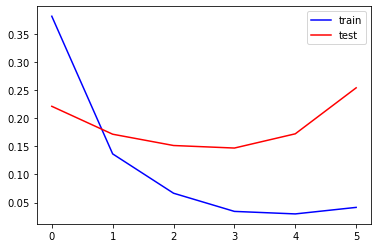

accuracy


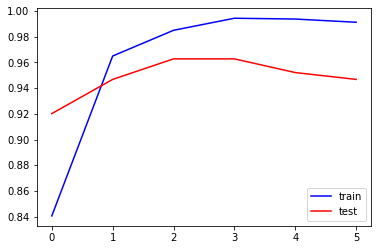

In [16]:
print('loss')
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(test_loss_list)), test_loss_list, 'r', label = 'test')
plt.legend()
plt.show()

print('accuracy')
plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, 'r', label = 'test')
plt.legend(loc = 4)
plt.show()

### save mode 

In [17]:
save_path = saver.save(sess, "./model/lstm_model") # 儲存模型到 /tmp/model.ckpt
print(save_path)

./model/lstm_model


### Freeze model

In [18]:
with tf.Session() as sess:

    #初始化variable
    sess.run(tf.global_variables_initializer())

    #擷取最新的checkpoint
    latest_ckpt = tf.train.latest_checkpoint('./model/')

    #載入graph
    restore_saver = tf.train.import_meta_graph('./model/lstm_model.meta')

    #恢复图，即将weights等参数加入图对应位置中
    restore_saver.restore(sess, latest_ckpt)
    #print(tf.get_collection('training_collection'))  # get_collection返回list，裡面存放訓練模型時候的變數
        
    #graph variable轉為常量
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, ["output_layer/class_probability"] )
    
    #graph寫入pb file
    model_f = tf.gfile.GFile("./model/frozen_model.pb","wb")
    model_f.write(output_graph_def.SerializeToString())
    print ('{} ops in the final graph.'.format(len(output_graph_def.node)))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/lstm_model
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 5 variables.
INFO:tensorflow:Converted 5 variables to const ops.
306 ops in the final graph.
